<h2>Imports

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import efficientnet_v2
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical

In [ ]:
#Loading the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()


In [ ]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")

In [ ]:
#Data Augementation
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = datagen.flow(x_train, y_train, batch_size=32)

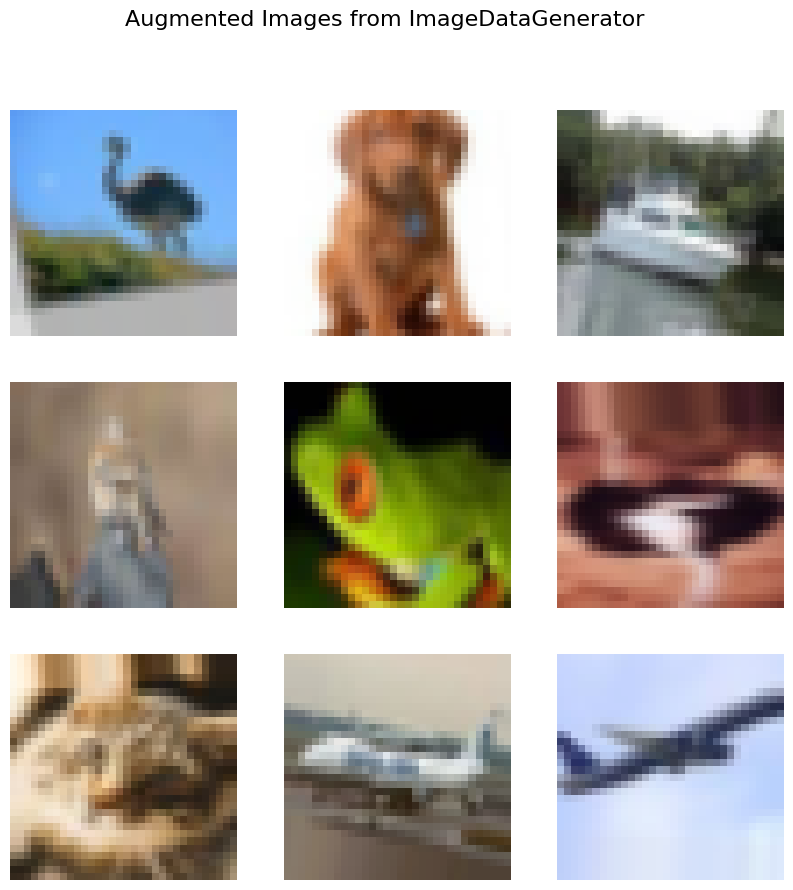

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    image, label = next(train_generator)
    plt.subplot(3, 3, i + 1)
    plt.imshow(image[0].astype('uint8'))
    plt.axis('off')
plt.suptitle('Augmented Images from ImageDataGenerator', fontsize=16)
plt.show()

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#for hyperparameter tuning, change the optimizer and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#early_stopping is used to prevent the model from overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
)

# The ReduceLROnPlateau callback gradually decreases the learning rate during the later stages of training,
# allowing the model to fine-tune and better capture the underlying patterns in the data.
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=1e-7,
)

In [ ]:
#Training the model
plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=1, verbose=1)
earlystopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1)
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=(x_test, y_test),
                    callbacks=[plateau, earlystopping])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 64s 36ms/step - accuracy: 0.2189 - loss: 2.5135 - val_accuracy: 0.4215 - val_loss: 1.5701 - learning_rate: 0.0010
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 62s 26ms/step - accuracy: 0.3725 - loss: 1.7306 - val_accuracy: 0.4795 - val_loss: 1.4373 - learning_rate: 0.0010
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 78s 24ms/step - accuracy: 0.4200 - loss: 1.6241 - val_accuracy: 0.4852 - val_loss: 1.4105 - learning_rate: 0.0010
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - accuracy: 0.4446 - loss: 1.5570 - val_accuracy: 0.5308 - val_loss: 1.2943 - learning_rate: 0.0010
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 36s 23ms/step - accuracy: 0.4682 - loss: 1.5056 - val_accuracy: 0.5547 - val_loss: 1.2630 - learning_rate: 0.0010
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - accuracy: 0.4827 - loss: 1.4756 - val_accuracy: 0.5578 - val_loss: 1.2320 - learning_rate: 0.0010
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 39s 23ms/step - accuracy: 0.4942 

In [ ]:
def evaluate_model_Plot(model, x_test, y_test, history):
    # Evaluate the model
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
    print(f'Test accuracy: {test_acc}')
    print(f'Test loss: {test_loss}')

    # Plot accuracy and loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Loss')
    plt.show()

    # Convert y_test to class labels
    y_test_labels = np.argmax(y_test, axis=-1)

    # Predict and convert y_pred to class labels
    y_pred = np.argmax(model.predict(x_test), axis=-1)

    # Confusion Matrix
    cm = confusion_matrix(y_test_labels, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(y_test.shape[1]), yticklabels=range(y_test.shape[1]))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(y_test_labels, y_pred, target_names=[str(i) for i in range(y_test.shape[1])]))


313/313 - 1s - 2ms/step - accuracy: 0.6664 - loss: 0.9940
Test accuracy: 0.6664000153541565


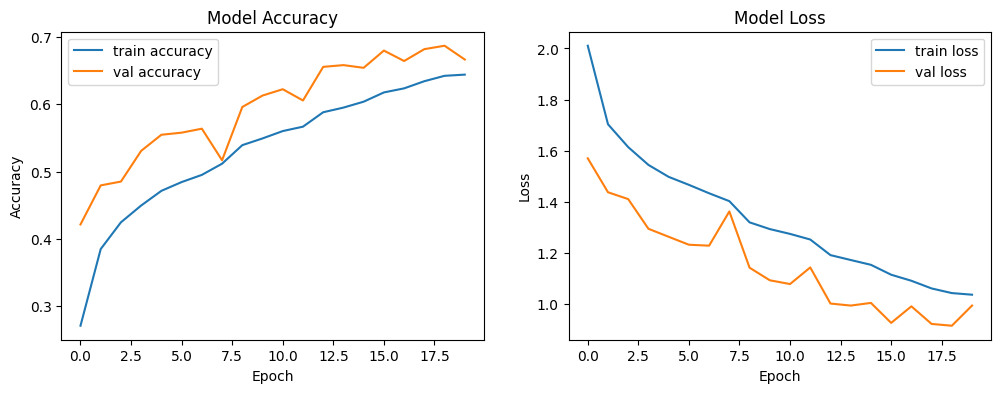

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


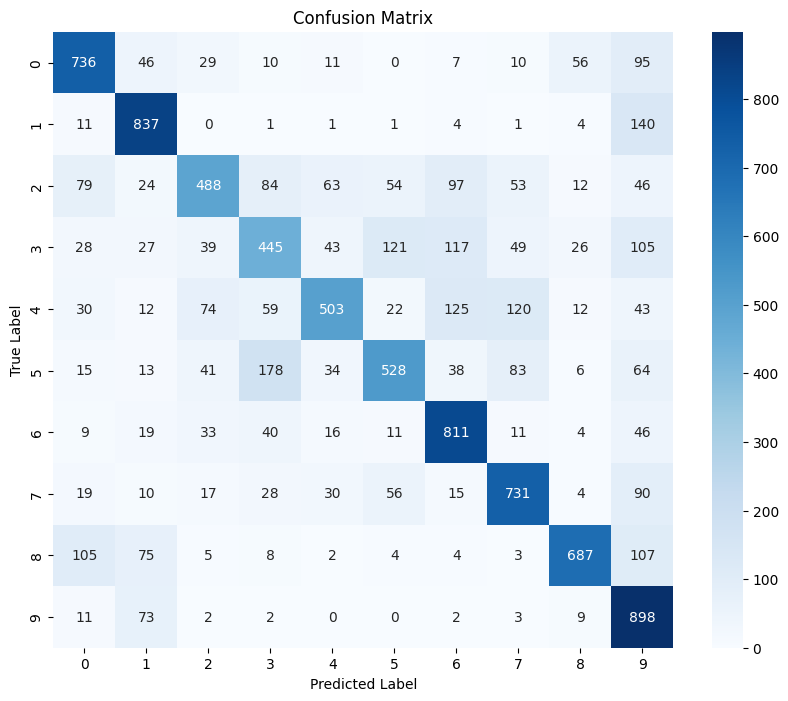

              precision    recall  f1-score   support

           0       0.71      0.74      0.72      1000
           1       0.74      0.84      0.78      1000
           2       0.67      0.49      0.56      1000
           3       0.52      0.45      0.48      1000
           4       0.72      0.50      0.59      1000
           5       0.66      0.53      0.59      1000
           6       0.66      0.81      0.73      1000
           7       0.69      0.73      0.71      1000
           8       0.84      0.69      0.75      1000
           9       0.55      0.90      0.68      1000

    accuracy                           0.67     10000
   macro avg       0.68      0.67      0.66     10000
weighted avg       0.68      0.67      0.66     10000



In [ ]:
evaluate_model_Plot(model, x_test, y_test, history)

# Using Pre-trained models

In [ ]:
input_shape = (32, 32, 3) #Cifar10 image size
resized_shape = (224, 224, 3) #EfficientNetV2B0 model input shape
num_classes = 10

def pre_trained_model():
    inputs = Input(shape=input_shape)
    x = tf.keras.layers.Lambda(lambda image: tf.image.resize(image, resized_shape[:2]))(inputs) #Resize image to  size 224x224
    base_model = efficientnet_v2.EfficientNetV2B0(include_top=False, input_shape=resized_shape, weights="imagenet")
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model = pre_trained_model()

plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=1, verbose=1)
earlystopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1)

model.compile(optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,932,122 (22.63 MB)

 Trainable params: 5,871,514 (22.40 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [ ]:
history = model.fit(train_generator,
                    epochs=50,
                    validation_data=(x_test, y_test),
                    callbacks=[plateau, earlystopping])

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 299s 147ms/step - accuracy: 0.7171 - loss: 0.8204 - val_accuracy: 0.9335 - val_loss: 0.1946 - learning_rate: 0.0100
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 179s 114ms/step - accuracy: 0.9063 - loss: 0.2752 - val_accuracy: 0.9514 - val_loss: 0.1489 - learning_rate: 0.0100
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 202s 114ms/step - accuracy: 0.9306 - loss: 0.2028 - val_accuracy: 0.9601 - val_loss: 0.1199 - learning_rate: 0.0100
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9432 - loss: 0.1660
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.006999999843537807.
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 203s 115ms/step - accuracy: 0.9432 - loss: 0.1660 - val_accuracy: 0.9576 - val_loss: 0.1294 - learning_rate: 0.0100
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 178s 114ms/step - accuracy: 0.9587 - loss: 0.1165 - val_accuracy: 0.9689 - val_loss: 0.0996 - learning_rate: 0.0070
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 201s 113ms/ste

313/313 - 9s - 29ms/step - accuracy: 0.9749 - loss: 0.0842
Test accuracy: 0.9749000072479248


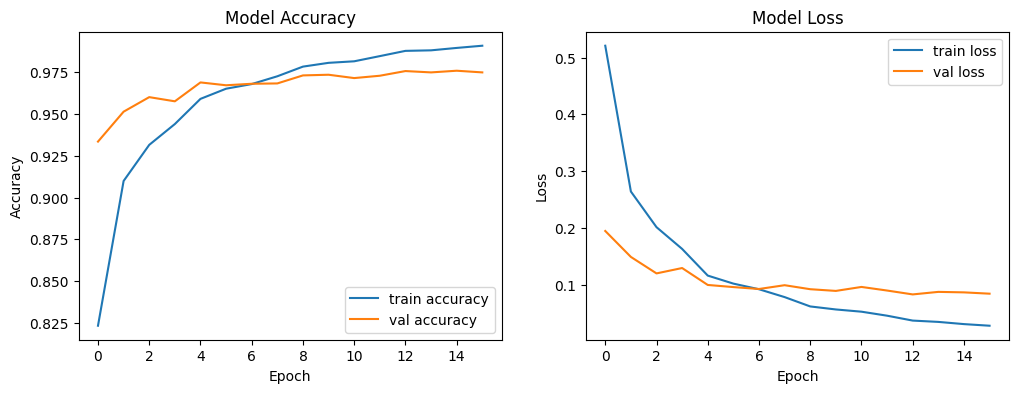

313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step


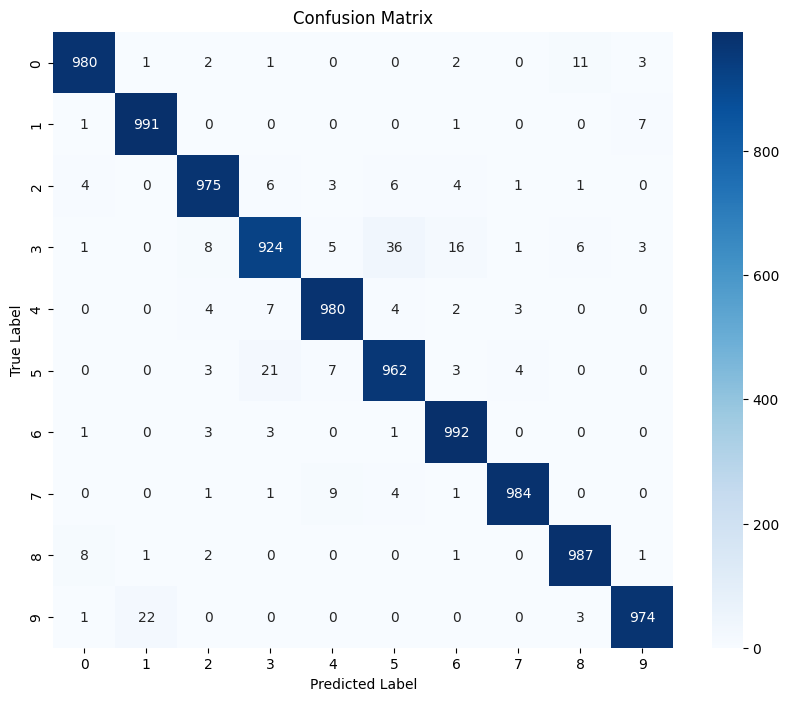

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1000
           1       0.98      0.99      0.98      1000
           2       0.98      0.97      0.98      1000
           3       0.96      0.92      0.94      1000
           4       0.98      0.98      0.98      1000
           5       0.95      0.96      0.96      1000
           6       0.97      0.99      0.98      1000
           7       0.99      0.98      0.99      1000
           8       0.98      0.99      0.98      1000
           9       0.99      0.97      0.98      1000

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [ ]:
evaluate_model_Plot(model, x_test, y_test, history)